In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

def pull_data():
    df = pd.read_csv('../data/life-expectancy.csv')
    df = df.loc[df['Code'] == 'USA']
    df.reset_index(drop=True, inplace=True)
    df = df.drop(index =0)
    df = df.drop(index =1)
    df.rename(columns={"Period life expectancy at birth - Sex: total - Age: 0": "Life Expectancy",}, inplace = True)
    df.drop(columns=["Entity", "Code"], inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df 


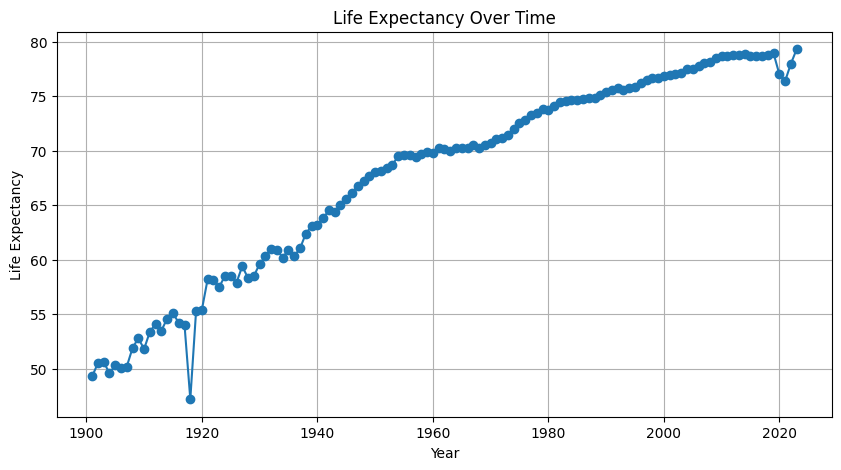

In [10]:
df = pull_data()

plt.figure(figsize=(10,5))
plt.plot(df['Year'], df['Life Expectancy'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Life Expectancy')
plt.title('Life Expectancy Over Time')
plt.grid(True)
plt.show()

In [18]:
result_original = adfuller(df["Life Expectancy"])

print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

if result_original[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

#second order differencing
df['Life Expectancy_Diff'] = df['Life Expectancy'].diff().diff()

result_diff = adfuller(df['Life Expectancy_Diff'].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")
if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.")
else:
    print("Interpretation: The differenced series is Non-Stationary.")

ADF Statistic (Original): -2.5285
p-value (Original): 0.1087
Interpretation: The original series is Non-Stationary.

ADF Statistic (Differenced): -6.2236
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


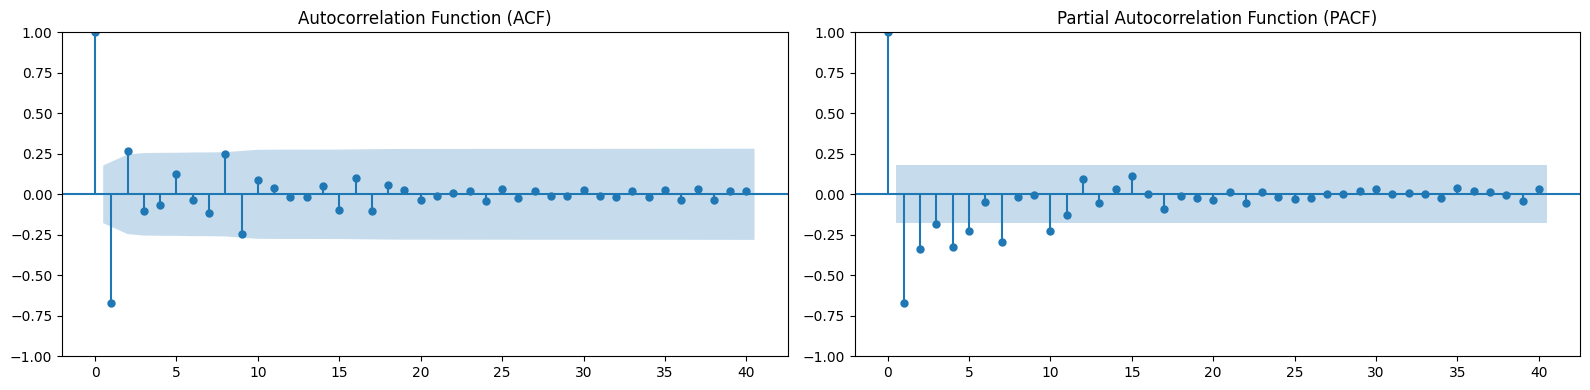

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(df['Life Expectancy_Diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(df['Life Expectancy_Diff'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

#p --> 3 or 4 
#q --> 2 or 3 
#d --> 2

#(p, d, q)

In [27]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

model = ARIMA(train[""], order=(1,1,1))
model_fit = model.fit()

,Year,Life Expectancy,Life Expectancy_Diff
98,1999,76.6691,-0.1512
99,2000,76.8058,0.1268
100,2001,76.9194,-0.0231
101,2002,76.9883,-0.0447
102,2003,77.1369,0.0797
103,2004,77.5350,0.2495
104,2005,77.5264,-0.4067
105,2006,77.7976,0.2798
106,2007,78.0471,-0.0217
107,2008,78.1273,-0.1693
